In [87]:
from datasets import load_dataset
import numpy as np
import os
from PIL import Image, ImageDraw

In [88]:
MODEL_NAME = "microsoft/conditional-detr-resnet-50"  # or "facebook/detr-resnet-50"

In [89]:
mcity_fe = load_dataset("dbogdollumich/mcity_fisheye", token=True)
print(mcity_fe["train"][0])

IMAGE_WIDTH = mcity_fe["train"][0]["image"].size[0]
IMAGE_HEIGHT = mcity_fe["train"][0]["image"].size[1]

mcity_fe["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x960 at 0x7F0718315AE0>, 'objects': {'bbox': [[310.0, 502.0, 34.0, 71.0], [290.0, 687.0, 17.0, 38.0], [479.0, 152.0, 53.0, 26.0], [843.0, 314.0, 67.0, 62.0], [948.0, 370.0, 36.0, 48.0], [1001.0, 399.0, 28.0, 40.0], [1039.0, 434.0, 12.0, 29.0], [810.0, 377.0, 98.0, 77.0], [1027.0, 465.0, 17.0, 30.0], [1068.0, 481.0, 11.0, 27.0], [1087.0, 498.0, 7.0, 15.0], [888.0, 286.0, 49.0, 48.0], [981.0, 343.0, 27.0, 44.0], [1024.0, 379.0, 20.0, 35.0], [206.0, 508.0, 11.0, 21.0], [191.0, 496.0, 13.0, 29.0], [1099.0, 499.0, 4.0, 14.0], [1050.0, 341.0, 10.0, 10.0]], 'categories': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 4]}}


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x960>,
 'objects': {'bbox': [[310.0, 502.0, 34.0, 71.0],
   [290.0, 687.0, 17.0, 38.0],
   [479.0, 152.0, 53.0, 26.0],
   [843.0, 314.0, 67.0, 62.0],
   [948.0, 370.0, 36.0, 48.0],
   [1001.0, 399.0, 28.0, 40.0],
   [1039.0, 434.0, 12.0, 29.0],
   [810.0, 377.0, 98.0, 77.0],
   [1027.0, 465.0, 17.0, 30.0],
   [1068.0, 481.0, 11.0, 27.0],
   [1087.0, 498.0, 7.0, 15.0],
   [888.0, 286.0, 49.0, 48.0],
   [981.0, 343.0, 27.0, 44.0],
   [1024.0, 379.0, 20.0, 35.0],
   [206.0, 508.0, 11.0, 21.0],
   [191.0, 496.0, 13.0, 29.0],
   [1099.0, 499.0, 4.0, 14.0],
   [1050.0, 341.0, 10.0, 10.0]],
  'categories': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 4]}}

In [90]:
from transformers import AutoImageProcessor

# https://huggingface.co/docs/transformers/v4.44.2/en/model_doc/detr#transformers.DetrImageProcessor
image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": IMAGE_HEIGHT, "max_width": IMAGE_WIDTH},
    do_pad=True,
    pad_size={"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH},
)

In [91]:
import albumentations as A

train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="coco", label_fields=["category"], clip=True, min_area=25
    ),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)

In [92]:
def format_image_annotations_as_coco(image_id, categories, bboxes):
    """Format one set of image annotations to the COCO format

    Args:
        image_id (str): image id. e.g. "0001"
        categories (List[int]): list of categories/class labels corresponding to provided bounding boxes
        areas (List[float]): list of corresponding areas to provided bounding boxes
        bboxes (List[Tuple[float]]): list of bounding boxes provided in COCO format
            ([x_min, y_min, width, height] in absolute coordinates)

    Returns:
        dict: {
            "image_id": image id,
            "annotations": list of formatted annotations
        }
    """

    annotations = []
    for category, bbox in zip(categories, bboxes):
        _, _, width, height = bbox
        area = width * height
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }

Visualize the data with the newly converted labels

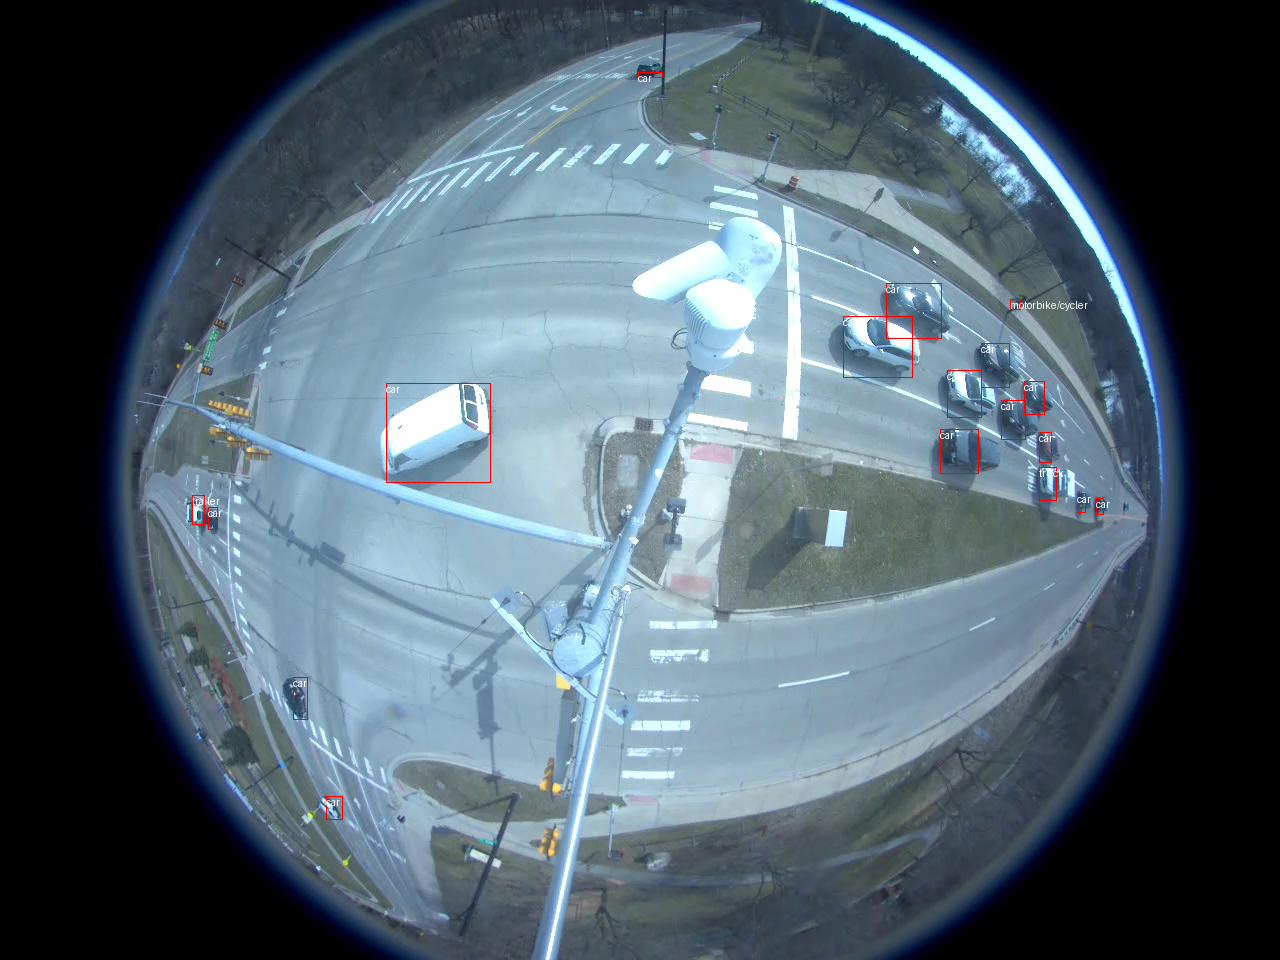

In [93]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = mcity_fe["train"][2]["image"]
image_width = image.size[0]
image_height = image.size[1]
annotations = mcity_fe["train"][2]["objects"]
draw = ImageDraw.Draw(image)

categories = mcity_fe["train"].features["objects"]["categories"].feature.names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(mcity_fe["train"][0]["objects"]["bbox"])):
    box = annotations["bbox"][i]
    class_idx = annotations["categories"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [94]:
def augment_and_transform_batch(
    examples, transform, image_processor, return_pixel_mask=False
):
    """Apply augmentations and format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    image_id = 1
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations
        output = transform(
            image=image, bboxes=objects["bbox"], category=objects["categories"]
        )
        images.append(output["image"])

        # format annotations in COCO format
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], output["bboxes"]
        )
        annotations.append(formatted_annotations)
        image_id += 1

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(
        images=images, annotations=annotations, return_tensors="pt"
    )

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

In [95]:
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(
    augment_and_transform_batch,
    transform=train_augment_and_transform,
    image_processor=image_processor,
)
validation_transform_batch = partial(
    augment_and_transform_batch,
    transform=validation_transform,
    image_processor=image_processor,
)

mcity_fe["train"] = mcity_fe["train"].with_transform(train_transform_batch)
mcity_fe["validation"] = mcity_fe["validation"].with_transform(
    validation_transform_batch
)

Generate batches and support for differently sized images: Pad images (which are now pixel_values) to the largest image in a batch, and create a corresponding pixel_mask to indicate which pixels are real (1) and which are padding (0)

In [96]:
import torch


def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data

In [97]:
from transformers.image_transforms import center_to_corners_format


def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

Compute metrics

In [98]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(
            logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes)
        )
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(
        classes, map_per_class, mar_100_per_class
    ):
        class_name = (
            id2label[class_id.item()] if id2label is not None else class_id.item()
        )
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

In [99]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([8]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([8, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./model",
    num_train_epochs=50,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    push_to_hub=False,
)

In [101]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mcity_fe["train"],
    eval_dataset=mcity_fe["validation"],
    tokenizer=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
  1%|          | 10/1250 [00:08<16:37,  1.24it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
  4%|▎         | 45/1250 [00:36<15:42,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 10%|▉         | 119/1250 [01:34<14:41,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / 

{'eval_loss': 2.342618703842163, 'eval_map': 0.0075, 'eval_map_50': 0.0244, 'eval_map_75': 0.0022, 'eval_map_small': 0.0032, 'eval_map_medium': 0.0685, 'eval_map_large': 0.107, 'eval_mar_1': 0.0043, 'eval_mar_10': 0.0263, 'eval_mar_100': 0.0376, 'eval_mar_small': 0.0426, 'eval_mar_medium': 0.1341, 'eval_mar_large': 0.1534, 'eval_map_car': 0.0593, 'eval_mar_100_car': 0.1797, 'eval_map_truck': 0.0002, 'eval_mar_100_truck': 0.049, 'eval_map_bus': 0.0003, 'eval_mar_100_bus': 0.0692, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.0, 'eval_mar_100_pedestrian': 0.0032, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.0, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 58.7019, 'eval_samples_per_second': 12.674, 'eval_steps_per_second': 1.584, 'epoch': 1.0}


 23%|██▎       | 288/1250 [04:45<12:29,  1.28it/s]  /home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 24%|██▍       | 297/1250 [04:52<12:23,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 29%|██▊       | 358/1250 [05:40<11:38,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 29%|██▉       | 363/1250 [05:44<11:33,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations

{'loss': 3.2173, 'grad_norm': 27.417327880859375, 'learning_rate': 3.272542485937369e-05, 'epoch': 2.0}


/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)


                                               
                                                  
 40%|████      | 500/1250 [08:31<10:05,  1.24it/s]

{'eval_loss': 2.1346426010131836, 'eval_map': 0.0142, 'eval_map_50': 0.0407, 'eval_map_75': 0.0061, 'eval_map_small': 0.0064, 'eval_map_medium': 0.0821, 'eval_map_large': 0.1004, 'eval_mar_1': 0.0085, 'eval_mar_10': 0.024, 'eval_mar_100': 0.0333, 'eval_mar_small': 0.0288, 'eval_mar_medium': 0.1297, 'eval_mar_large': 0.135, 'eval_map_car': 0.1129, 'eval_mar_100_car': 0.2078, 'eval_map_truck': 0.0008, 'eval_mar_100_truck': 0.049, 'eval_map_bus': 0.0001, 'eval_mar_100_bus': 0.0096, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.0, 'eval_mar_100_pedestrian': 0.0003, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.0, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 60.6388, 'eval_samples_per_second': 12.269, 'eval_steps_per_second': 1.534, 'epoch': 2.0}


 43%|████▎     | 533/1250 [08:59<09:24,  1.27it/s]  /home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 44%|████▎     | 544/1250 [09:07<09:13,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 44%|████▎     | 546/1250 [09:09<09:09,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 56%|█████▌    | 695/1250 [11:04<07:07,  1.30it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations

{'eval_loss': 1.9805209636688232, 'eval_map': 0.0163, 'eval_map_50': 0.0443, 'eval_map_75': 0.0086, 'eval_map_small': 0.0074, 'eval_map_medium': 0.0937, 'eval_map_large': 0.1201, 'eval_mar_1': 0.0107, 'eval_mar_10': 0.0439, 'eval_mar_100': 0.0536, 'eval_mar_small': 0.0477, 'eval_mar_medium': 0.1835, 'eval_mar_large': 0.1751, 'eval_map_car': 0.1288, 'eval_mar_100_car': 0.2285, 'eval_map_truck': 0.0009, 'eval_mar_100_truck': 0.1115, 'eval_map_bus': 0.0006, 'eval_mar_100_bus': 0.0731, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.0002, 'eval_mar_100_pedestrian': 0.011, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.001, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 59.6289, 'eval_samples_per_second': 12.477, 'eval_steps_per_second': 1.56, 'epoch': 3.0}


 61%|██████    | 761/1250 [12:57<10:35,  1.30s/it]  /home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 64%|██████▎   | 794/1250 [13:23<05:56,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 68%|██████▊   | 847/1250 [14:04<05:12,  1.29it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 68%|██████▊   | 848/1250 [14:05<05:12,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations

{'loss': 1.773, 'grad_norm': 49.95726776123047, 'learning_rate': 4.7745751406263165e-06, 'epoch': 4.0}


/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)


                                               
                                                   
 80%|████████  | 1000/1250 [17:02<03:19,  1.26it/s]

{'eval_loss': 1.9038726091384888, 'eval_map': 0.0195, 'eval_map_50': 0.0495, 'eval_map_75': 0.0115, 'eval_map_small': 0.0094, 'eval_map_medium': 0.1032, 'eval_map_large': 0.1252, 'eval_mar_1': 0.014, 'eval_mar_10': 0.0506, 'eval_mar_100': 0.0606, 'eval_mar_small': 0.0564, 'eval_mar_medium': 0.1991, 'eval_mar_large': 0.1829, 'eval_map_car': 0.1532, 'eval_mar_100_car': 0.2472, 'eval_map_truck': 0.0013, 'eval_mar_100_truck': 0.1229, 'eval_map_bus': 0.001, 'eval_mar_100_bus': 0.0962, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.0003, 'eval_mar_100_pedestrian': 0.0138, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.0005, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0003, 'eval_runtime': 58.9536, 'eval_samples_per_second': 12.62, 'eval_steps_per_second': 1.578, 'epoch': 4.0}


/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 82%|████████▏ | 1026/1250 [17:24<02:53,  1.29it/s]  /home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 86%|████████▌ | 1069/1250 [17:57<02:21,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
 90%|█████████ | 1127/1250 [18:43<01:36,  1.28it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invali

{'eval_loss': 1.8874764442443848, 'eval_map': 0.02, 'eval_map_50': 0.0506, 'eval_map_75': 0.0122, 'eval_map_small': 0.0098, 'eval_map_medium': 0.1066, 'eval_map_large': 0.1218, 'eval_mar_1': 0.0131, 'eval_mar_10': 0.0507, 'eval_mar_100': 0.0607, 'eval_mar_small': 0.0624, 'eval_mar_medium': 0.1938, 'eval_mar_large': 0.177, 'eval_map_car': 0.158, 'eval_mar_100_car': 0.2512, 'eval_map_truck': 0.001, 'eval_mar_100_truck': 0.1187, 'eval_map_bus': 0.001, 'eval_mar_100_bus': 0.0981, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.0002, 'eval_mar_100_pedestrian': 0.013, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.001, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 58.7134, 'eval_samples_per_second': 12.672, 'eval_steps_per_second': 1.584, 'epoch': 5.0}




                                                     
100%|██████████| 1250/1250 [21:19<00:00,  1.02s/it]

{'train_runtime': 1279.4355, 'train_samples_per_second': 7.816, 'train_steps_per_second': 0.977, 'train_loss': 2.3284990478515626, 'epoch': 5.0}


TrainOutput(global_step=1250, training_loss=2.3284990478515626, metrics={'train_runtime': 1279.4355, 'train_samples_per_second': 7.816, 'train_steps_per_second': 0.977, 'total_flos': 9.58175059968e+18, 'train_loss': 2.3284990478515626, 'epoch': 5.0})

In [102]:
from pprint import pprint

metrics = trainer.evaluate(
    eval_dataset=mcity_fe["validation"], metric_key_prefix="test"
)
pprint(metrics)

/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:468: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - EPSILON)
100%|██████████| 93/93 [00:56<00:00,  1.64it/s]

{'epoch': 5.0,
 'test_loss': 1.8874764442443848,
 'test_map': 0.02,
 'test_map_50': 0.0506,
 'test_map_75': 0.0122,
 'test_map_bus': 0.001,
 'test_map_car': 0.158,
 'test_map_large': 0.1218,
 'test_map_medium': 0.1066,
 'test_map_motorbike/cycler': 0.0,
 'test_map_pedestrian': 0.0002,
 'test_map_pickup': 0.0,
 'test_map_small': 0.0098,
 'test_map_trailer': 0.0,
 'test_map_truck': 0.001,
 'test_map_van': 0.0,
 'test_mar_1': 0.0131,
 'test_mar_10': 0.0507,
 'test_mar_100': 0.0607,
 'test_mar_100_bus': 0.0981,
 'test_mar_100_car': 0.2512,
 'test_mar_100_motorbike/cycler': 0.0036,
 'test_mar_100_pedestrian': 0.013,
 'test_mar_100_pickup': 0.0,
 'test_mar_100_trailer': 0.0,
 'test_mar_100_truck': 0.1187,
 'test_mar_100_van': 0.001,
 'test_mar_large': 0.177,
 'test_mar_medium': 0.1938,
 'test_mar_small': 0.0624,
 'test_runtime': 57.9686,
 'test_samples_per_second': 12.835,
 'test_steps_per_second': 1.604}


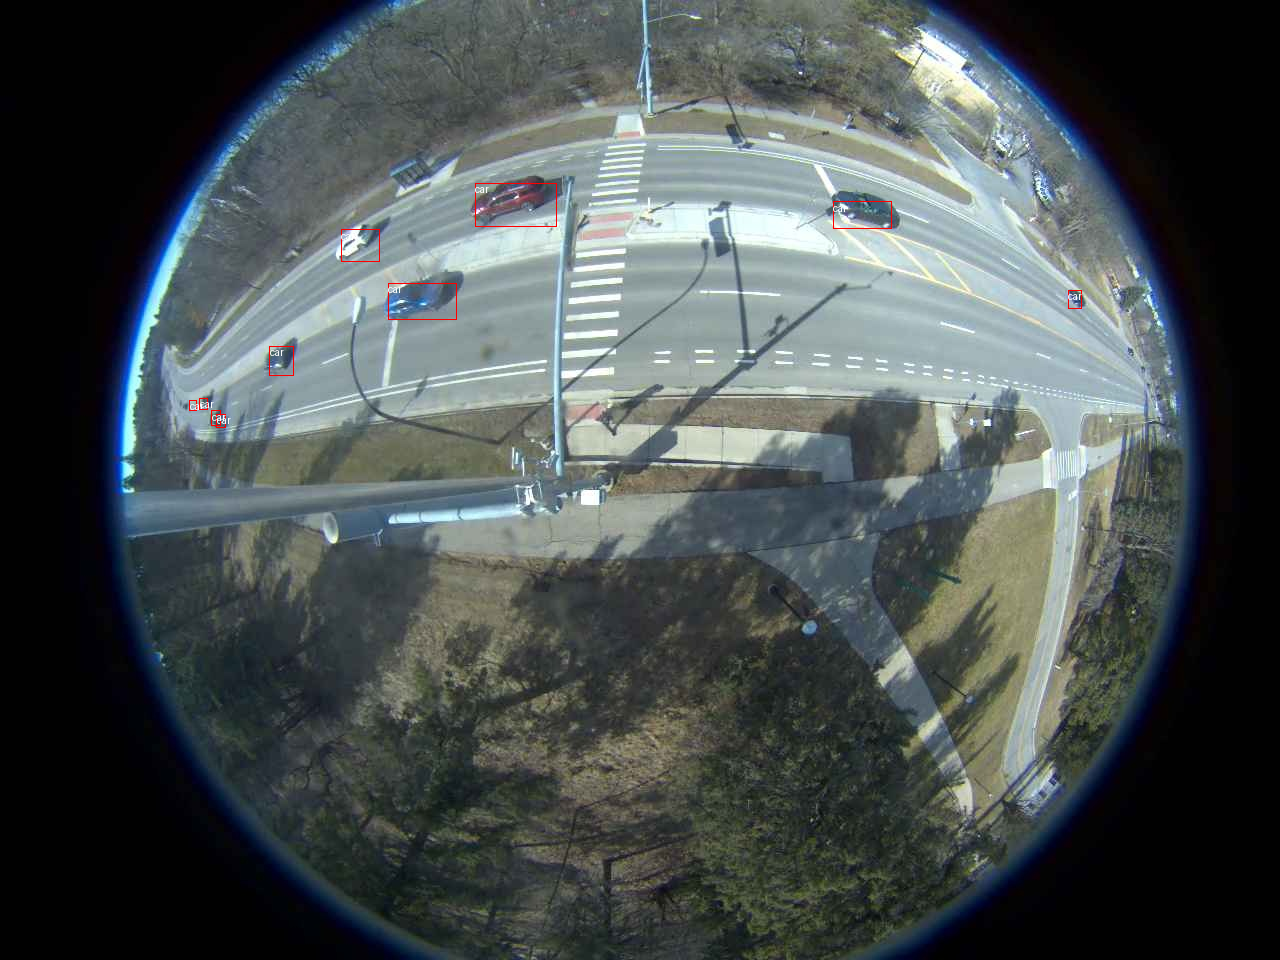

In [103]:
import torch
import requests

from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection

device = "cuda"

image = Image.open("./beal_clip10_2023-02-20_13-09-07-353621.jpg")
draw = ImageDraw.Draw(image)

with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(
        outputs, threshold=0.3, target_sizes=target_sizes
    )[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image